In [18]:
import cupy as cp

# Use numpy instead of cupy if you don't have a GPU
def relu(x):
    return cp.maximum(0, x)

def relu_derivative(x):
    return cp.where(x > 0, 1, 0)

def softmax(x):
    e_x = cp.exp(x - cp.max(x, axis=1, keepdims=True))
    return e_x / cp.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, targets):
    return -cp.sum(targets * cp.log(predictions + 1e-9)) / targets.shape[0]

def cross_entropy_loss_with_regularization(predictions, targets, W1, W2, reg_lambda):
    loss = cross_entropy_loss(predictions, targets)
    reg_loss = 0.5 * reg_lambda * (cp.sum(W1**2) + cp.sum(W2**2))
    return loss + reg_loss

def predict(x, W1, b1, W2, b2):
    z1 = cp.dot(x, W1.T) + b1
    a1 = relu(z1)
    z2 = cp.dot(a1, W2.T) + b2
    y_hat = softmax(z2)
    return cp.argmax(y_hat, axis=1)

def initialize_parameters(n_input=784, n_hidden=128, n_output=10):
    cp.random.seed(42)
    W1 = cp.random.randn(n_hidden, n_input) * 0.01
    b1 = cp.zeros(n_hidden)
    W2 = cp.random.randn(n_output, n_hidden) * 0.01
    b2 = cp.zeros(n_output)
    return W1, b1, W2, b2

def forward_propagation(x, W1, b1, W2, b2):
    z1 = cp.dot(x, W1.T) + b1
    a1 = relu(z1)
    z2 = cp.dot(a1, W2.T) + b2
    y_hat = softmax(z2)
    return z1, a1, z2, y_hat

def backward_propagation(x, y, W1, b1, W2, b2, a1, y_hat, reg_lambda):
    m = x.shape[0]
    delta_2 = y_hat - y
    dW2 = cp.dot(delta_2.T, a1) / m + reg_lambda * W2
    db2 = cp.sum(delta_2, axis=0) / m
    delta_1 = cp.dot(delta_2, W2) * relu_derivative(a1)
    dW1 = cp.dot(delta_1.T, x) / m + reg_lambda * W1
    db1 = cp.sum(delta_1, axis=0) / m
    return dW1, db1, dW2, db2

def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = cp.asarray(x_train.reshape(-1, 784) / 255.0)
    x_test = cp.asarray(x_test.reshape(-1, 784) / 255.0)
    y_train = cp.eye(10)[y_train]
    y_test = cp.eye(10)[y_test]
    return x_train, y_train, x_test, y_test

def train(x_train, y_train, W1, b1, W2, b2, eta, epochs, reg_lambda):
    for epoch in range(epochs):
        z1, a1, z2, y_hat = forward_propagation(x_train, W1, b1, W2, b2)
        loss = cross_entropy_loss_with_regularization(y_hat, y_train, W1, W2, reg_lambda)
        dW1, db1, dW2, db2 = backward_propagation(x_train, y_train, W1, b1, W2, b2, a1, y_hat, reg_lambda)
        W1 -= eta * dW1
        b1 -= eta * db1
        W2 -= eta * dW2
        b2 -= eta * db2
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")
    return W1, b1, W2, b2

if __name__ == "__main__":
    x_train, y_train, x_test, y_test = load_mnist()
    n_input, n_hidden, n_output = 784, 128, 10
    eta = 0.05
    epochs = 1000
    lambdas = [0.01, 0.02, 0.03, 0.04, 0.05]
    best_accuracy = 0
    best_params = None

    for reg_lambda in lambdas:
        W1, b1, W2, b2 = initialize_parameters(n_input, n_hidden, n_output)
        W1, b1, W2, b2 = train(x_train, y_train, W1, b1, W2, b2, eta, epochs, reg_lambda)
        predictions = predict(x_test, W1, b1, W2, b2)
        test_labels = cp.argmax(y_test, axis=1)
        accuracy = cp.mean(predictions == test_labels)
        print(f"Test Accuracy: {accuracy * 100:.2f}% with lambda = {reg_lambda}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (W1, b1, W2, b2)

    print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")

Epoch 100, Loss: 2.0046
Epoch 200, Loss: 1.0682
Epoch 300, Loss: 0.7958
Epoch 400, Loss: 0.7000
Epoch 500, Loss: 0.6530
Epoch 600, Loss: 0.6253
Epoch 700, Loss: 0.6070
Epoch 800, Loss: 0.5941
Epoch 900, Loss: 0.5844
Epoch 1000, Loss: 0.5767
Test Accuracy: 90.41% with lambda = 0.01
Epoch 100, Loss: 2.0736
Epoch 200, Loss: 1.1918
Epoch 300, Loss: 0.9376
Epoch 400, Loss: 0.8512
Epoch 500, Loss: 0.8093
Epoch 600, Loss: 0.7842
Epoch 700, Loss: 0.7674
Epoch 800, Loss: 0.7555
Epoch 900, Loss: 0.7465
Epoch 1000, Loss: 0.7397
Test Accuracy: 89.99% with lambda = 0.02
Epoch 100, Loss: 2.1325
Epoch 200, Loss: 1.2978
Epoch 300, Loss: 1.0556
Epoch 400, Loss: 0.9743
Epoch 500, Loss: 0.9351
Epoch 600, Loss: 0.9118
Epoch 700, Loss: 0.8964
Epoch 800, Loss: 0.8856
Epoch 900, Loss: 0.8778
Epoch 1000, Loss: 0.8720
Test Accuracy: 89.49% with lambda = 0.03
Epoch 100, Loss: 2.1827
Epoch 200, Loss: 1.3897
Epoch 300, Loss: 1.1565
Epoch 400, Loss: 1.0789
Epoch 500, Loss: 1.0422
Epoch 600, Loss: 1.0211
Epoch 700,

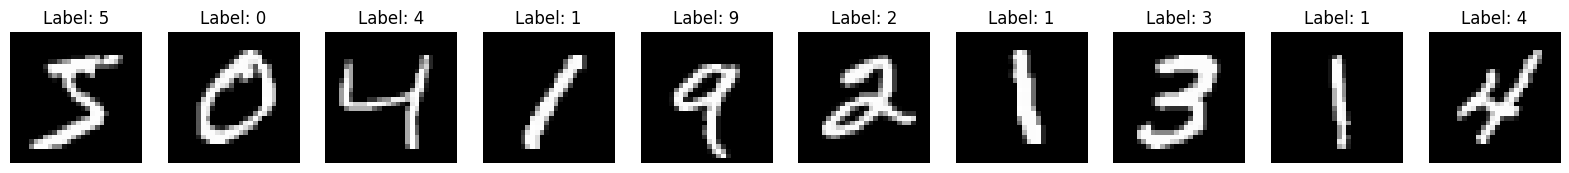

In [19]:
import matplotlib.pyplot as plt
import numpy as np 
x_train, y_train, x_test, y_test = load_mnist()
# print(biggest_accuracy)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i].reshape(28, 28).get(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {np.argmax(y_train[i])}')

plt.show()


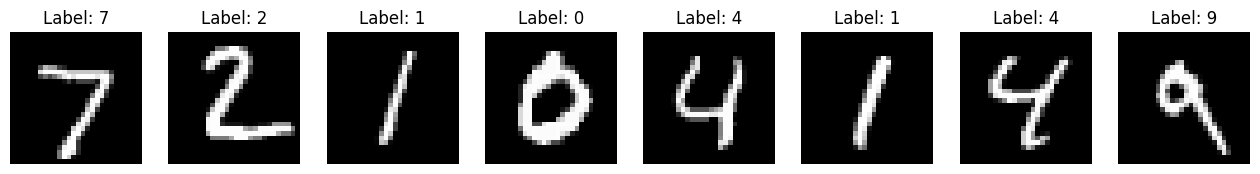

In [20]:
import matplotlib.pyplot as plt

x_train, y_train, x_test, y_test = load_mnist()

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_test[i].reshape(28, 28).get(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {np.argmax(y_test[i])}')

plt.show()

Accuracy: 90.41%


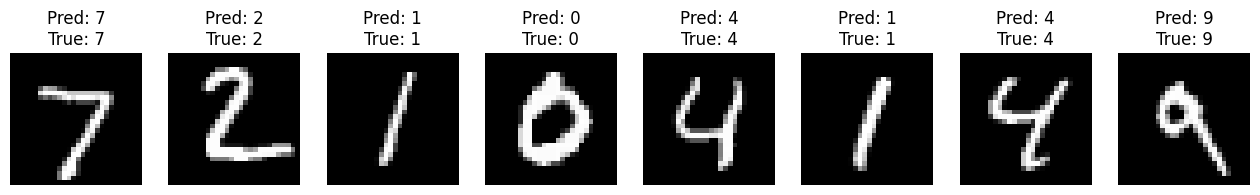

In [21]:
import matplotlib.pyplot as plt
import cupy as cp

W1, b1, W2, b2 = best_params
test_predictions = predict(x_test, W1, b1, W2, b2)
test_labels = cp.argmax(y_test, axis=1)  
accuracy = cp.mean(test_predictions == test_labels)  
print(f"Accuracy: {100 * accuracy.get():.2f}%")  

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, ax in enumerate(axes):
   
    ax.imshow(cp.asnumpy(x_test[i]).reshape(28, 28), cmap='gray')
    ax.axis('off')
   
    ax.set_title(f'Pred: {int(test_predictions[i].get())}\nTrue: {int(test_labels[i].get())}')

plt.show()
